# A spring-block system with rate and state friction


First we make an object containing the physical properties of the block.

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

class pb:
    def __init__(self):
        # Rate and state variables
        self.a = 0.01
        self.b = 0.011
        self.Dc = 1e-5
        self.RSF = 'c'

        # reference values
        self.v_star = 1e-5
        self.theta_star = self.Dc / self.v_star
        self.mu_star = 0.6

        # Forces
        self.P = 0.        # Pore pressure
        self.coh = 0.      # Cohesion
        self.L = 1e-4      # spring stiffness
        self.sigma = 5e6   # normal stress
        self.Vs = 3000     # shear-wave velocity
        self.smod = 2e9    # shear modulus
        self.imped = 0.5 * self.smod / self.Vs   # seismic radiation impedance
        
        # Initialization
        self.v = self.v_star
        self.theta = self.theta_star
        if self.RSF == 'c':
            self.tau = get_tau_c(self.v, self.theta, self)
            self.mu = get_mu_c(self.v, self.theta, self)
        elif self.RSF == 'r':
            self.tau = get_tau_r(self.v, self.theta, self)
            self.mu = get_mu_r(self.v, self.theta, self)

    def update(self):
        """Give initial values and update the object"""
        if self.RSF == 'c':
            self.tau = get_tau_c(self.v, self.theta, self)
            self.mu = get_mu_c(self.v, self.theta, self)
        elif self.RSF == 'r':
            self.tau = get_tau_r(self.v, self.theta, self)
            self.mu = get_mu_r(self.v, self.theta, self)

# ODEs of the state $\theta$ and rate $v$ evolution

The classical form of rate and state friction from [Rubin and Ampuero, 2005](http://doi.wiley.com/10.1029/2005JB003686):
$$\mu(V, \theta) = \mu^* + a\ln(\frac{V}{V^*}) + b\ln(\frac{\theta V^*}{D_c}) \tag{1}$$

There are two laws describing the evolution of state variable $\theta$. Here we use the aging law
$$\frac{d\theta}{dt} = 1 - \frac{\theta V}{D_c} \tag{2}$$

The change in velocity can be written as:
$$\frac{dv}{dt} = \frac{\frac{d\tau}{dt} - \sigma\frac{d\mu}{d\theta}\frac{d\theta}{dt}}{\sigma\frac{d\mu}{dv}-Impedence} \tag{3}$$

The impedance, or seismic radiation damping approximate the inertia of the crust ([Rice, 1993](http://doi.wiley.com/10.1029/93JB00191)) to make this simulation quasi-dynamic.

We integrate the two ODEs (1) and (2). And the friction coefficient $\mu$ is updated using the updated $\theta$ and $v$.

In [2]:
#------------ Classic form ---------------------
def dtheta_dt(z, Dc):
    """We use the aging law as the state evolution"""
    theta, v = z
    return 1 - v * theta / Dc


def get_mu_c(theta, v, pb):
    """Classical R&S friction"""
    return pb.mu_star - pb.a*np.log(pb.v_star/ v ) + pb.b * np.log(theta/pb.theta_star)


def dmu_dv_dtheta_c(theta, v, pb):
    """Calculate dmu/dtheta and dmu/dv"""
    dmu_dtheta = pb.b / theta
    dmu_dv = pb.a / v
    return dmu_dv, dmu_dtheta


def dv_dt_c(t, z, pb):
    """Calculate dv/dt"""
    theta, v = z
    dthdt = dtheta_dt(z, pb.Dc)
    pb.mu = get_mu_c(theta, v, pb)
    pb.tau = get_tau_c(theta, v, pb)
    dtau_dt = get_dtau_dt(pb.mu, v-pb.v_star, pb.L)
    dmu_dv, dmu_dtheta = dmu_dv_dtheta_c(theta, v, pb)
    dvdt = (dtau_dt - pb.sigma*dmu_dtheta + pb.sigma*dmu_dtheta*v*theta/pb.Dc)/(pb.sigma*dmu_dv + pb.imped)
    return [dthdt, dvdt]


def get_jac(t, z, pb):
    """Calculate the Jacobian matrix of the two ODEs. Only feasable for the classical form."""
    theta, v = z
    dtau_dt = get_dtau_dt(pb.mu, v-pb.v_star, pb.L)
    df1dy1 = -v / pb.Dc
    df1dy2 = -theta / pb.Dc
    df2dy1 = pb.b*pb.sigma*pb.v / ((pb.a*pb.sigma + pb.imped*v)*theta**2)
    df2dy2 = pb.sigma*(pb.a*(-pb.Dc*pb.b*pb.sigma + pb.Dc*dtau_dt*theta + pb.b*pb.sigma*theta*v)+ pb.b*theta*v*(pb.imped*v + pb.a*pb.sigma))/(pb.Dc*theta*(pb.imped*v + pb.a*pb.sigma)**2)
    return np.array([[df1dy1, df1dy2], [df2dy1, df2dy2]])

A weakness in the classical form is that when velocity approach zero, stress can become negative. [Lapusta et al., 2000](http://doi.wiley.com/10.1029/2000JB900250) use the regularized form that is stable when velocity approach zero:
$$\tau = a\bar\sigma\sinh^{-1}[\frac{V}{2V_0}\exp(\frac{f_0+b\ln(\frac{V_0\theta}{L})}{a})] \tag{4}$$

Here you can choose the regularized form by setting `pb.RSF = 'r'`

In [3]:
#-------- Regularized form --------------------
def get_mu_r(theta, v, pb):
    """Regularize form of R&S friction"""
    return pb.a * np.arcsinh(v/(2 * pb.v_star) \
           * np.exp((pb.mu_star + pb.b * np.log(theta/pb.theta_star))/pb.a))


def dmu_dv_dtheta_r(theta, v, pb):
    z = np.exp((pb.mu_star + pb.b * np.log(theta/pb.theta_star)) / pb.a) / (2*pb.v_star)
    dmu_dv = pb.a / np.sqrt(1./z**2 + v**2)
    dmu_dtheta = dmu_dv * (pb.b*v) / (pb.a*theta)
    return dmu_dv, dmu_dtheta


def dv_dt_r(t, z, pb):
    theta, v = z
    dthdt = dtheta_dt(z, pb.Dc)
    pb.mu = get_mu_r(theta, v, pb)
    pb.tau = get_tau_r(theta, v, pb)
    dtau_dt = get_dtau_dt(pb.mu, v-pb.v_star, pb.L)
    dmu_dv, dmu_dtheta = dmu_dv_dtheta_r(theta, v, pb)
    dvdt = (dtau_dt - pb.sigma*dmu_dtheta + pb.sigma*dmu_dtheta*v*theta/pb.Dc)/(pb.sigma * dmu_dv + pb.imped)
    # print(pb.tau, pb.mu)
    return [dthdt, dvdt]

Finally we calculate shear stress and its derivative
$$\tau = (\sigma - P)*\mu + cohesion \tag{5}$$
$$\frac{d\tau}{dt} = -\frac{\mu v}{L} \tag{6}$$

In [4]:
def get_tau_c(theta, v, pb):
    return (pb.sigma - pb.P) * get_mu_c(theta, v, pb) + pb.coh

def get_tau_r(theta, v, pb):
    return (pb.sigma - pb.P) * get_mu_r(theta, v, pb) + pb.coh

# Stress
def get_dtau_dt(mu, v, L):
    """1D spring-block
    v = v - v_star (usually v_star == v_pl)"""
    return -mu * v / L

Prepare the plotting function

In [5]:
def plot_sol(sol, jump=20):
    fig = plt.figure(figsize=[16, 5])
    tp = fig.add_subplot(131)
    tp.scatter(sol.t[::20], sol.y[0,::jump], s=0.5)
    tp.set_yscale('log')
    tp.set_xlabel('Time')
    tp.set_ylabel(r'$\theta$')
    tp.set_title('State')
    vp = fig.add_subplot(132)
    vp.scatter(sol.t[::jump], sol.y[1,::jump], s=0.5)
    vp.set_yscale('log')
    vp.set_xlabel('Time')
    vp.set_ylabel('Velocity (m/s)')
    vp.set_title('Rate')
    pd = fig.add_subplot(133)
    pd.scatter(sol.y[0, ::jump], sol.y[1, ::jump], s=0.5)
    pd.set_xscale('log')
    pd.set_xlabel(r'$\theta$')
    pd.set_yscale('log')
    pd.set_ylabel('v')
    plt.show()
    print('Number of time steps: ', len(sol.t))

# Solve ODEs!
Here we use the solve_ivp (initial-value problem) in scipy.integrate to see which ODE solver is more powerful.

## We first use the classical explicit solver Runge-Kutta of order 5.

CPU times: user 7min 48s, sys: 12.2 s, total: 8min
Wall time: 10min 38s


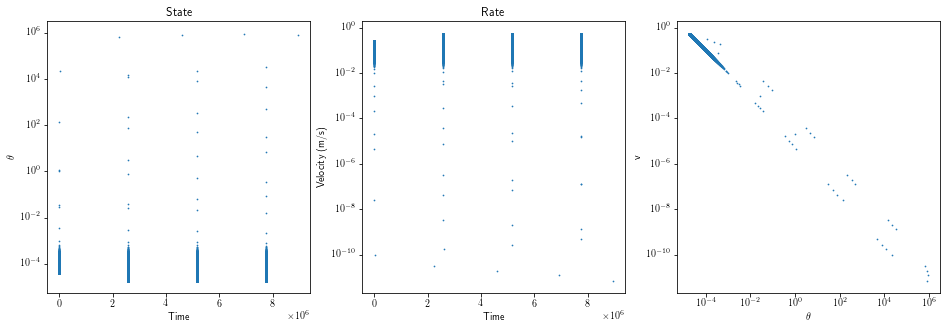

Number of time steps:  1530007


In [7]:
# Initialize the problem
p = pb()
p.RSF = 'c'
p.v = 2e-5    # pluck the block
p.update()

%time sol = solve_ivp(fun=dv_dt_c, t_span=(0, 1e7), y0=[p.theta, p.v], method='RK45', args=[p], atol=0., rtol=1e-5, dense_output=True)
plot_sol(sol, jump=20)

So it takes several minutes to calculate a spring block evolving for 1e7 seconds or 115 days

Why does it take so long to solve? The rate and state ODEs are constantly on very different scales. When velocity is very small most of the time, the solver is forced to take very small steps. These kind of equations are known as "stiff." We can swap the classical solver with implicit solver to improve the efficiency.

## An implicit solver "BDF", or backward differentiation formula
We also provide the Jacobian matrix needed for implicit solvers.

CPU times: user 20.3 s, sys: 1.74 s, total: 22.1 s
Wall time: 25.1 s


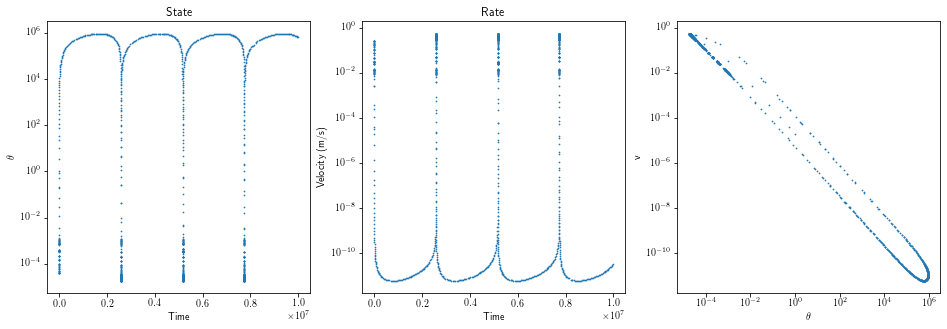

Number of time steps:  29112


In [18]:
p = pb()
p.RSF = 'c'
p.v = 2e-5    # pluck the block
p.update()

%time sol = solve_ivp(fun=dv_dt_c, t_span=(0, 1e7), y0=[p.theta, p.v], method='BDF', args=[p], atol=1e-6, rtol=1e-7, jac=get_jac, dense_output=True)
plot_sol(sol, jump=20)

So it takes about 2 minutes to calculate a spring block evolving for 1e7 seconds or 115 days using the same atol and rtol.

## Use the LSODA solver developed by the LLNL
LSODA uses Adams/BDF method with automatic stiffness detection and switching.

CPU times: user 947 ms, sys: 31.8 ms, total: 979 ms
Wall time: 1.06 s


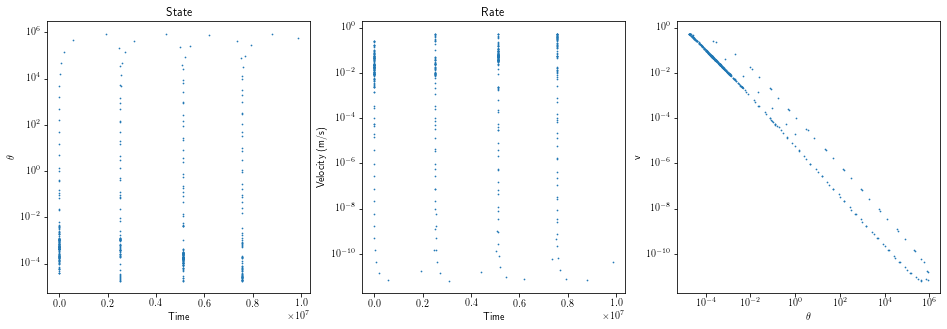

Number of time steps:  8609


In [19]:
p = pb()
p.RSF = 'c'
p.v = 2e-5    # pluck the block
p.update()

%time sol = solve_ivp(fun=dv_dt_c, t_span=(0, 1e7), y0=np.array([p.theta, p.v]), method='LSODA', args=[p], atol=0., rtol=1e-5, jac=get_jac, dense_output=True)
plot_sol(sol, jump=20)

# Conclusion
**LSODA** is so fast its scary!!